In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize, scale, PolynomialFeatures
from sklearn.cluster import AgglomerativeClustering,KMeans
from scipy.cluster import hierarchy
from mpl_toolkits.mplot3d import Axes3D
import pylab

Load data and preprocess the data

In [2]:
#load all studies
files = ['Study_A.csv','Study_B.csv','Study_C.csv','Study_D.csv','Study_E.csv']
trials = []
for file in files:
    trials.append(pd.read_csv(file))
allTrialsDF= pd.concat(trials, sort = False)

In [3]:
#ERROR value in 'Country' variable needs to be corrected
#60014 --> USA
#60025 --> Russia
pd.set_option('mode.chained_assignment', None) #cancel the warning 
allTrialsDF['Country'][(allTrialsDF.Country == "ERROR") & (allTrialsDF.SiteID==60014)] = "USA"
allTrialsDF['Country'][(allTrialsDF.Country == "ERROR") & (allTrialsDF.SiteID==60025)] = "RUSSIA"

#Factorize the TxGroup (make control/Treatment to 0/1)
allTrialsDF['TxGroup'] = pd.factorize(allTrialsDF.TxGroup)[0]

#sort the data by patient and visits
allSortedDF = allTrialsDF.sort_values(['PatientID', 'VisitDay'], ascending=[True, True]).reset_index().drop(['index'],axis=1)


#get sum of Ps,Ns,Gs
Ps=['P1', 'P2', 'P3', 'P4', 'P5','P6', 'P7']
Gs=['G1','G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12', 'G13', 'G14', 'G15','G16']
Ns=['N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7']
allSortedDF['Ps'] = allSortedDF[Ps].sum(axis=1)
allSortedDF['Gs'] = allSortedDF[Gs].sum(axis=1)
allSortedDF['Ns'] = allSortedDF[Ns].sum(axis=1)

#diff of PANSS_Total
allSortedDF['PANSS_Total_diff_1'] = allSortedDF.groupby('PatientID')['PANSS_Total'].diff()
#(diff() function: first discrete difference of objects over the given axis)


In [4]:
firstVisits = allSortedDF.groupby('PatientID').first()[['PANSS_Total','Ps','Gs','Ns']+Ps+Ns+Gs]
# normalize the data and create a df out of it
firstVisitsScaled = normalize(firstVisits,axis=0)
firstVisitsScaledDF = pd.DataFrame(firstVisitsScaled, columns=firstVisits.columns)


labels = firstVisits.index.values
linked = hierarchy.linkage(firstVisitsScaledDF, 'complete',metric='euclidean')


In [17]:
# Use original K means (initialize central point randomly)

In [5]:
X = firstVisitsScaledDF

In [6]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans_cluster = kmeans.f
it(X)
y_kmeans = kmeans_cluster.predict(X)

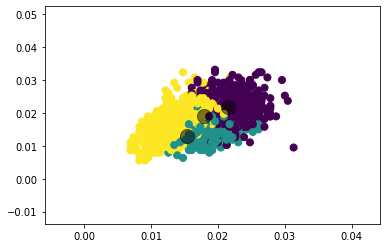

In [9]:
plt.scatter(X['Gs'], X['Ns'], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [18]:
#Get the centor points from the complete linkage clustering

In [22]:
numClusters = 3
aggClustering = AgglomerativeClustering(n_clusters=numClusters, affinity='euclidean', linkage='complete')
aggClusteringFit = aggClustering.fit_predict(firstVisits)

D:\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


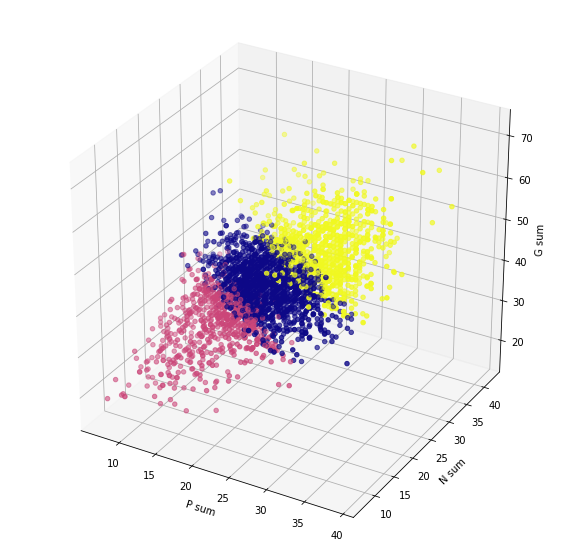

In [23]:
kMeansCenters = []
#get centers from previous clustering
for k in np.unique(aggClusteringFit):
    #for each parameter
    kthMeans = []
    for p in firstVisits.columns:
        #compute mean
        kthMeans.append(np.mean(firstVisits[p].loc[aggClustering.labels_ == k]))
    kMeansCenters.append(np.asarray(kthMeans))
    
kMeansClusters = KMeans(n_clusters=numClusters,init=np.asarray(kMeansCenters),random_state=1).fit(firstVisits)

#plot
fig = plt.figure(figsize=(10, 10)) 
ax = fig.add_subplot(111, projection='3d')

img = ax.scatter(firstVisits.Ps,firstVisits.Ns, firstVisits.Gs, c=kMeansClusters.labels_,cmap='plasma_r', marker='o')
# fig.colorbar(img)

ax.set_xlabel('P sum')
ax.set_ylabel('N sum')
ax.set_zlabel('G sum')

plt.show()
fig.savefig('KNN.png', dpi=500)

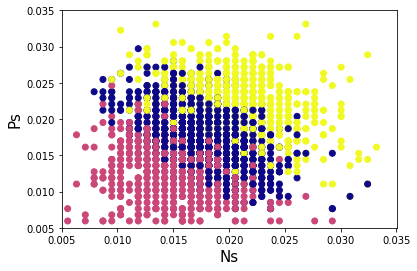

In [25]:
plt.scatter(X['Ns'], X['Ps'], c=kMeansClusters.labels_, cmap='plasma_r')
#plt.xticks(range(0.05, 0.035))
plt.xlabel("Ns", fontsize = 15)
plt.ylabel("Ps", fontsize = 15)
pylab.ylim([0.005, 0.035])
pylab.xlim([0.005, 0.035])

plt.show()


#centers = kmeans.cluster_centers_
#plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

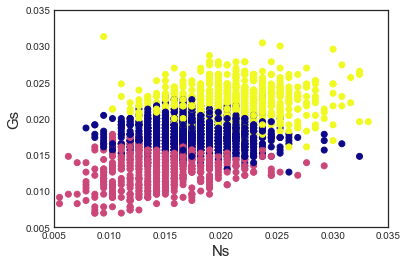

<Figure size 720x720 with 0 Axes>

In [33]:
plt.scatter(X['Ns'], X['Gs'], c=kMeansClusters.labels_, cmap='plasma_r')
#plt.xticks(range(0.05, 0.035))
plt.xlabel("Ns", fontsize = 15)
plt.ylabel("Gs", fontsize = 15)
pylab.ylim([0.005, 0.035])
pylab.xlim([0.005, 0.035])

plt.show()
fig = plt.figure(figsize=(10, 10)) 
fig.savefig('NsGs.png', dpi=500)
#centers = kmeans.cluster_centers_
#plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [29]:
#SSE vs. number of clusters

In [27]:
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

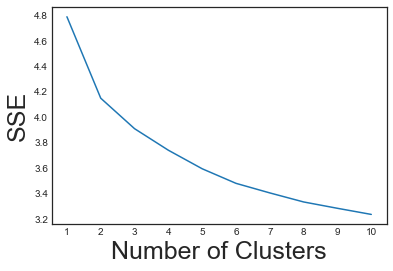

In [28]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.style.use("seaborn-white")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters", fontsize = 25)
plt.ylabel("SSE", fontsize = 25)
plt.show()